# Lane Detection using FCN

<u>Teammates</u>:

1.   Mohit Dharmik (2019A7PS0032G)
2.   Garvit Singh (2019A7PS0073G)



# Section 1: Importing the required libraries

In this section, we will import all the necessary libraries required by our code. Additionally we will be setting the device to the GPU to get a better processing power. At last, we will be setting the seed for our random processes to ensure reproducibility.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# colab libraries
from google.colab import drive
from google.colab.patches import cv2_imshow

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(784)

In [ ]:
np.random.seed(54)

# Section 2: Data Loading and Processing
This section mainly deals with loading our dataset to the local environment and processing its data to the required formats so as to ensure all the datatypes and dimensions are in accordance with our model.

### The Dataset
The Dataset we are going to use in this notebook is a dataset for Lanes Detection in an autonomous car driving agent [(DataSet)](https://www.kaggle.com/datasets/thomasfermi/lane-detection-for-carla-driving-simulator).

<br> Above dataset contains image frames captured by a dashcam that is installed in a simulated vehicle. The label images are segmentation masks. This aligns closely with our research interests since the research paper we chose to work upon deals with segmentation and it's loss functions for detection of lanes on the road and to create an output image highlighting (or masking) the lane distribution.
<br> Another reason we chose this dataset is that the creators of our research paper chose a dataset very similar to this one which can be found by clicking [here](https://www.kaggle.com/datasets/manideep1108/tusimple).

<br> The dataset is ensured to be balanced since it contains different types of samples like left or right turning roads, straight roads, flyovers and bisected roads. The dataset also contains at max 4 to 6 lanes providing us with a balance in data sampling.

<br> The limitations to our dataset is that it only contains traffic-free road images, which means the model we will develop might fail to detect lanes for heavily traficated roads.

## Mount Drive and Path Directories

We have uploaded the dataset to our google drive. In this step we will be using google.colab library to load our dataset from the drive.

### <b>Please read this before proceeding</b>

1. To load the dataset, visit this link to the dataset present on our drive : "https://drive.google.com/drive/folders/1jI43wDb1KTox-BfMgX1UU-VAb2Zvvgtj?usp=sharing".
2. Then create a shortcut of this folder in your google drive by just clicking the name of the folder and clicking on "Add shorcut to Drive" and selecting the directory as "MyDrive".
3. (Make sure this shortcut is present in the "MyDrive" directory of your google drive.)

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Project Dataset'
TRAIN_PATH = BASE_PATH + '/train_unzipped'
TRAIN_LABEL_PATH = BASE_PATH + '/train_label_unzipped'
VAL_PATH = BASE_PATH + '/val_unzipped'
VAL_LABEL_PATH = BASE_PATH + '/val_label_unzipped'

In [ ]:
#this function returns a list of 
def import_data(INPUT_PATH: str, LABEL_PATH: str, final_dimension: tuple, input_id_index : tuple, label_id_index : tuple, is_val: bool = False):

    inputs = []
    labels = []

    files = os.listdir(INPUT_PATH)
    label_files = os.listdir(LABEL_PATH)

    for index, file in enumerate(files):

        if (not is_val) and index % 3 > 0:
            continue

        try:
            idx = (int) (file[ input_id_index[0] : input_id_index[1] ])
        except:
            continue

        image = cv2.imread(INPUT_PATH+"/"+file)
        image = cv2.resize(image, final_dimension)
        inputs.append(image)

        for label_file in label_files:
        
            label_idx = (int)(label_file[ label_id_index[0] : label_id_index[1] ])

            if(idx == label_idx):
                label_image = cv2.imread(LABEL_PATH+"/"+label_file)
                label_image = cv2.resize(label_image, final_dimension)
                labels.append(label_image)
                break

    inputs = np.array(inputs)
    inputs = inputs/255
    labels = np.array(labels)
    labels = labels/255

    return (inputs, labels)

In [ ]:
reduced_dims = (192, 96)

In [ ]:
# the below 4 variables denotes the idx indices for the file names

train_input_id_index = (44, -4)   # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png
train_label_id_index = (44, -10)  # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png

val_input_id_index = (44, -19)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png
val_label_id_index = (44, -25)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png

In [ ]:
train_x, train_y = import_data(TRAIN_PATH, TRAIN_LABEL_PATH, reduced_dims, train_input_id_index, train_label_id_index)
val_x, val_y = import_data(VAL_PATH, VAL_LABEL_PATH, reduced_dims, val_input_id_index, val_label_id_index, True)

### Dimensions

Training Set contains 3100 images which are boiled down to 1026 since many frames have only slight change from eachother since they are frames of video. So our model will not learn anything useful from such redundant data.
Validation Set contains 400 images which are again boiled down to 129 images for the same reason.

Dimensions of Images have been reduces from (500 x 1000) to (96 x 192) because of limited computation power.

In [ ]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(1026, 96, 192, 3) (1026, 96, 192, 3)
(129, 96, 192, 3) (129, 96, 192, 3)


## Data Visualizing

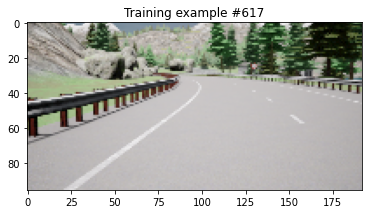

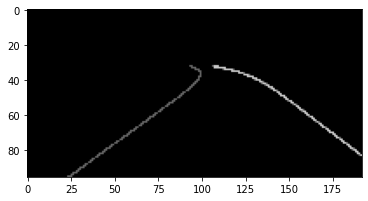

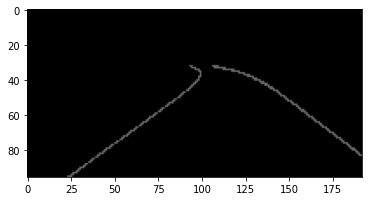

In [ ]:
i = np.random.randint(0, len(train_x))
plt.imshow(train_x[i])
plt.title(f"Training example #{i}")
plt.show()
plt.imshow(train_y[i]*100)
plt.show()
plt.imshow(np.where(train_y[i] != 0, 1, 0)*100)
plt.show()

# Section 3: Model Architechture

The basic idea used behind the architechure (used in the research paper) is to use auto encoders for semantic/instance segmentation. This implementation will be purely based on the Pytorch's framework and we will be using several inbuilt functions to ensure a readable, optimised and light-weight code. However, our current model does not have same channels in upscaling layers. They follow U-Net mechanism as of now.

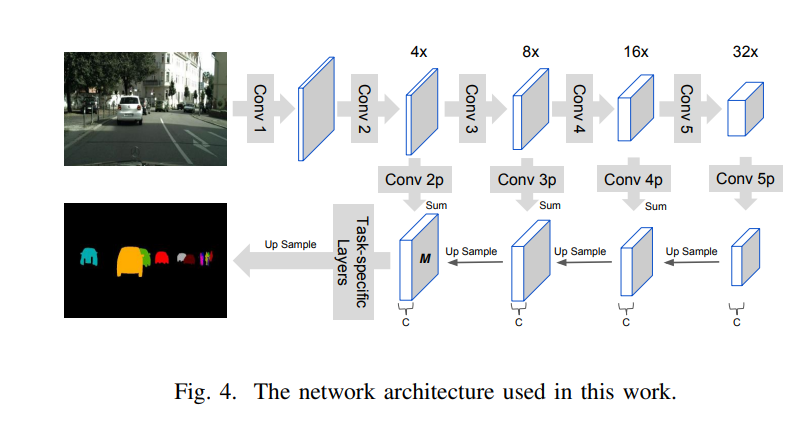

## Model Implementation

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class NeuralNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[16, 32, 64, 128],
    ):
        super(NeuralNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of NeuralNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of NeuralNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## Model Summary

This subsection will demonstrate the model behavious at each layer in a tabular form (basically representing the dimensions of the outputs and the number of parameters at these layers). 

In [ ]:
input_dim = (3, 96, 192)

In [ ]:
from torchsummary import summary
testing_model = NeuralNet()

# while working on CPU
# summary(testing_model, input_dim)

# while working on GPU
summary(testing_model.cuda(), input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 96, 192]             432
       BatchNorm2d-2          [-1, 16, 96, 192]              32
              ReLU-3          [-1, 16, 96, 192]               0
            Conv2d-4          [-1, 16, 96, 192]           2,304
       BatchNorm2d-5          [-1, 16, 96, 192]              32
              ReLU-6          [-1, 16, 96, 192]               0
        DoubleConv-7          [-1, 16, 96, 192]               0
         MaxPool2d-8           [-1, 16, 48, 96]               0
            Conv2d-9           [-1, 32, 48, 96]           4,608
      BatchNorm2d-10           [-1, 32, 48, 96]              64
             ReLU-11           [-1, 32, 48, 96]               0
           Conv2d-12           [-1, 32, 48, 96]           9,216
      BatchNorm2d-13           [-1, 32, 48, 96]              64
             ReLU-14           [-1, 32,

# Section 4: Creating Ground Matrices
The ground matrices will be created by the labels of our dataset and will be a 4 dimensional matrice with 1 channel. The 1st dimension represents each image. The follwing 2 dimensions represents each pixel in an image. The last dimension consist of a values in range 0 to 1 denoting the probability of that pixel to be a non-background pixel. 

In [ ]:
ground = []
ground_val = []

In [ ]:
def get_ground(train_y):
    ground = np.mean(train_y, axis=3, keepdims=True)
    ground = np.where(ground != 0, 10*ground, 0)
    np.expand_dims(ground, 1)
    return ground

In [ ]:
ground = get_ground(train_y)
ground_val = get_ground(val_y)

In [ ]:
ground.shape

(1026, 96, 192, 1)

In [ ]:
ground_val.shape

(129, 96, 192, 1)

#### Ground Translation Visualisation

In [ ]:
# tells us how many points are non-background in example i
i = np.random.randint(1026)
print("example #" + str(i))
p = (ground[i] != 0).sum()
print("number of non-background pixels #" + str(p))
q = (ground[i] == 0).sum()
print("number of total pixels #" + str(p+q))

example #17
number of non-background pixels #193
number of total pixels #18432


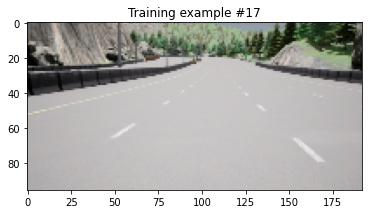

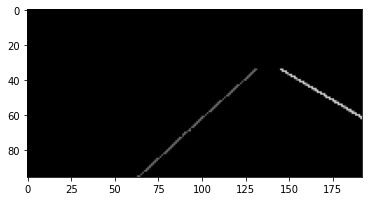

In [ ]:
plt.imshow(train_x[i])
plt.title(f"Training example #{i}")
plt.show()
plt.imshow(train_y[i]*100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(96, 192, 3)


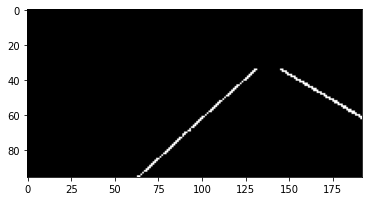

In [ ]:
g = ground[i]*(np.ones(shape=(96, 192, 3)))
print(g.shape)
plt.imshow(g*100)

# Section 5: Training and Validation

This section will be dealing with training the model through our training set.

#### HyperParameters

deals with initializing the hyperparameters of our model.

In [ ]:
lr = 0.01
batch_size = 32
momentum = 0.5
epochs = 40

#### Shapes

In [ ]:
train_x.shape 

(1026, 96, 192, 3)

In [ ]:
train_y.shape

(1026, 96, 192, 3)

In [ ]:
val_x.shape

(129, 96, 192, 3)

In [ ]:
val_y.shape

(129, 96, 192, 3)

In [ ]:
ground.shape

(1026, 96, 192, 1)

In [ ]:
ground_val.shape

(129, 96, 192, 1)

#### Model Initialisation

Deals with initializing the parameters of our model. However, as per latest settings we saw that uninitialised model parameters are giving better results than initialised once. So we will not be using them as of now.

In [ ]:
model = NeuralNet(in_channels=3, out_channels=1).to(device)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


#### Loss Function

The loss function we will be using is the Mean Squared Error function. This is the best working function from the ones we have explored so far which included several custom and built-in functions. Some of the functions we have explored are namely:
 
*   Binary Cross Entropy, which gave all black images as output, equivalent to having no prediction at all (98% accuracy).
*   Binary Cross Entropy with logits which worked similar to BCE (98% accuracy).
*   A custom loss function which failed to reduce the loss to a convergance(less than 40% accuracy).
*   Mean Squared Error, giving roughly 45 to 50 % accuracy (and best case 64%) but not giving pure black images, thus making some some predictions as compared to BCE loss function which was giving higher accuracy but not making predictions.

Thus we chose MSE as our loss function, since it was the only one to give some predictions and doing some learning. Though we are still far away from getting a good accuracy, Our Final Goal will be to use the loss function in accordance with the reseach paper which can provide us better fit and predictions.



In [ ]:
loss_fn = nn.MSELoss()

#### Optimizer
We chose the Stochastic Gradient Descent as suggested in the research paper.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr, momentum)
scaler = torch.cuda.amp.GradScaler()

#### Training and Validation

In [ ]:
train_losses = []
validation_losses = []

In [ ]:
model.train()
# model.apply(initialize_weights)

n = len(train_x)

for epoch in range(epochs):

    train_loss = 0.0

    for i in range( n//batch_size ):

        input = torch.from_numpy(train_x[i: i+batch_size]).float()
        input = input.to(device)

        # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
        input = input.transpose(1, 3)
        input = input.transpose(2, 3)

        # 10 x 1 x 96 x 192
        output = torch.from_numpy(ground[i: i+batch_size]).float()
        output = output.to(device)

        # changing from 10 x 96 x 192 x 1 to 10 x 1 x 96 x 192
        output = output.transpose(1, 3)
        output = output.transpose(2, 3)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(input)                  # 10 x 1 x 96 x 192
            loss = loss_fn(predictions, output)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update losses
        train_loss += loss.item()
        
        # if i % 5 == 0:
        #     print("Loss after " + str(i*batch_size) + " examples is " + str(train_loss))

    
    print("Loss after epoch " + str(epoch) + " is : " + str(loss.item()))
    train_losses.append(train_loss)


Loss after epoch 0 is : 0.014046513475477695
Loss after epoch 1 is : 0.007233565207570791
Loss after epoch 2 is : 0.004796084947884083
Loss after epoch 3 is : 0.003548278706148267
Loss after epoch 4 is : 0.0027978899888694286
Loss after epoch 5 is : 0.0023032829631119967
Loss after epoch 6 is : 0.001954244216904044
Loss after epoch 7 is : 0.0016950430581346154
Loss after epoch 8 is : 0.0014943163841962814
Loss after epoch 9 is : 0.001334781525656581
Loss after epoch 10 is : 0.0012051103403791785
Loss after epoch 11 is : 0.0010972711024805903
Loss after epoch 12 is : 0.0010071620345115662
Loss after epoch 13 is : 0.0009301910176873207
Loss after epoch 14 is : 0.0008638407452963293
Loss after epoch 15 is : 0.0008061514818109572
Loss after epoch 16 is : 0.0007550275768153369
Loss after epoch 17 is : 0.0007103663519956172
Loss after epoch 18 is : 0.0006700352532789111
Loss after epoch 19 is : 0.0006340257241390646
Loss after epoch 20 is : 0.0006014078971929848
Loss after epoch 21 is : 0.00

In [ ]:
model.eval()

num_correct = 0.0
num_pixels = 0.0

m = len(val_x)
_, h, w, _ = ground.shape

with torch.no_grad():
    for i in range(m):

        input = torch.from_numpy(val_x[i]).float()
        input = torch.unsqueeze(input, axis = 0)
        input = input.to(device)

        # # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
        input = input.transpose(1, 3)
        input = input.transpose(2, 3)

        # 10 x 1 x 96 x 192
        output = torch.from_numpy(ground[i]).float()
        output = torch.unsqueeze(output, axis = 0)
        output = output.to(device)

        output = output.transpose(1, 3)
        output = output.transpose(2, 3)

        predictions = torch.sigmoid(model(input))
        predictions = (predictions > 0.5).float()

        num_correct = (predictions == output).type(torch.float).sum().item()
        num_pixels = (float) (h*w)

        print("White : " + str((output != 0).sum().item()) + ", Black : " + str((output == 0).sum().item()))
        print("Correctly Predicted : " + str(num_correct) + ", Wrongly Predicted : " + str(num_pixels - num_correct))
        
        print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))


White : 254, Black : 18178
Correctly Predicted : 8640.0, Wrongly Predicted : 9792.0
Accuracy for validation Sample 0 is :0.46875
White : 283, Black : 18149
Correctly Predicted : 8929.0, Wrongly Predicted : 9503.0
Accuracy for validation Sample 1 is :0.4844292534722222
White : 249, Black : 18183
Correctly Predicted : 8399.0, Wrongly Predicted : 10033.0
Accuracy for validation Sample 2 is :0.4556749131944444
White : 287, Black : 18145
Correctly Predicted : 8708.0, Wrongly Predicted : 9724.0
Accuracy for validation Sample 3 is :0.4724392361111111
White : 294, Black : 18138
Correctly Predicted : 8780.0, Wrongly Predicted : 9652.0
Accuracy for validation Sample 4 is :0.4763454861111111
White : 283, Black : 18149
Correctly Predicted : 8046.0, Wrongly Predicted : 10386.0
Accuracy for validation Sample 5 is :0.4365234375
White : 292, Black : 18140
Correctly Predicted : 9275.0, Wrongly Predicted : 9157.0
Accuracy for validation Sample 6 is :0.5032009548611112
White : 245, Black : 18187
Correctl

# Section 6: Visualise Prediction and Output

In [ ]:
i = np.random.randint(129)

#### Process

In [ ]:
with torch.no_grad():
    input = torch.from_numpy(val_x[i]).float()
    input = torch.unsqueeze(input, axis = 0)
    input = input.to(device)

    # # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
    input = input.transpose(1, 3)
    input = input.transpose(2, 3)

    # 10 x 1 x 96 x 192
    output = torch.from_numpy(ground[i]).float()
    output = torch.unsqueeze(output, axis = 0)
    output = output.to(device)

    output = output.transpose(1, 3)
    output = output.transpose(2, 3)

    predict = model(input)
    prediction = torch.sigmoid(model(input))
    prediction = (prediction > 0.5).float()

    num_correct = (prediction == output).type(torch.float).sum().item()
    num_pixels = (float) (h*w)

    print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))


Accuracy for validation Sample 30 is :0.4697265625


#### Visuals

In [ ]:
broad_caster = np.ones(shape=(96, 192, 3))

(96, 192, 3)


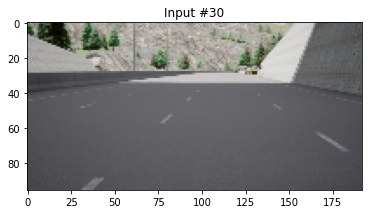

In [ ]:
plt.title(f"Input #{i}")
plt.imshow(train_x[i])
print(train_x[i].shape)
plt.show()

(96, 192, 3)


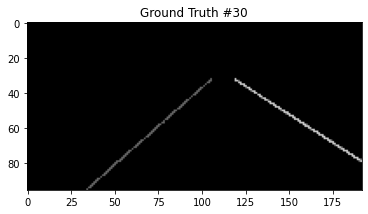

In [ ]:
plt.title(f"Ground Truth #{i}")
plt.imshow(train_y[i]*100)
print(train_y[i].shape)
plt.show()

(96, 192, 3)


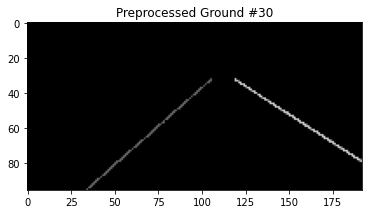

In [ ]:
plt.title(f"Preprocessed Ground #{i}")
g = ground[i]*broad_caster
plt.imshow(g*100)
print(g.shape)
plt.show()

torch.Size([1, 1, 96, 192])
torch.Size([1, 96, 192])
torch.Size([96, 192, 1])
(96, 192, 1)
0
(96, 192, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


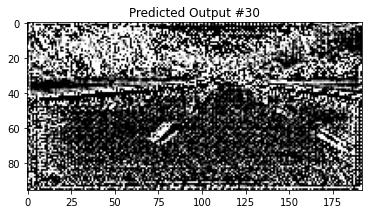

In [ ]:
with torch.no_grad():
    ip = torch.from_numpy(val_x[i]).float()
    ip = torch.unsqueeze(ip, axis = 0)
    ip = ip.to(device)
    # # changing from 10 x 96 x 192 x 3 to 10 x 3 x 96 x 192
    ip = ip.transpose(1, 3)
    ip = ip.transpose(2, 3)

    y_pred = model(ip)

    print(y_pred.shape)

    y_pred = y_pred[0]
    print(y_pred.shape)

    y_pred = y_pred.transpose(0, 1)
    y_pred = y_pred.transpose(1, 2)
    print(y_pred.shape)

    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()
    print(y_pred.shape)

    print((y_pred==0).sum())

    y_pred = y_pred*broad_caster
    print(y_pred.shape)

    plt.title(f"Predicted Output #{i}")
    plt.imshow(y_pred*100)
    plt.show()

## Analysis of Output
Seeing the results, we can conclude that the model tends to learn the distribution of object boundaries in the input image however our aim was to just target the lane distribution. We failed to set the primary target of our model.

# Section 7: Conclusion

We are yet far from achieving good predictions and our next goal is to find a better loss function which will be able to train our model better.

# Section 8: References

1. Research Paper : https://ieeexplore.ieee.org/abstract/document/8489379

2. Current Dataset : https://www.kaggle.com/datasets/thomasfermi/lane-detection-for-carla-driving-simulator

3. Backup Dataset : https://www.kaggle.com/datasets/manideep1108/culane

4. Model Architecture : 
<br>https://en.m.wikipedia.org/wiki/U-Net
<br>https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/




In [ ]:
# ok done!